In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MaxNLocator
from pandas.tseries.offsets import DateOffset
from datetime import datetime

In [48]:
def extract_values(data):
    """
    Extract all values from the input data, supporting both single and multiple series.
    Handles DataFrame, dictionary of DataFrames, or nested dictionaries.
    """
    if isinstance(data, pd.DataFrame):  # Single DataFrame
        return data.values.flatten()
    elif isinstance(data, dict):  # Dictionary of series
        all_values = []
        for series in data.values():
            if isinstance(series, pd.DataFrame):  # DataFrame in dictionary
                all_values.extend(series['value'].values)
            elif isinstance(series, dict):  # Nested dictionary
                all_values.extend(series.values())
        return np.array(all_values)
    else:
        raise ValueError("Input data must be a DataFrame or a dictionary of series.")

def calculate_data_range(values, buffer_ratio=0.1, min_buffer=1.0):
    """
    Calculate min/max with an enforced dynamic buffer to avoid tight y-axis limits.
    """
    vmin = np.min(values)
    vmax = np.max(values)
    range_ = vmax - vmin
    buffer = max(range_ * buffer_ratio, min_buffer)
    return vmin - buffer, vmax + buffer

def configure_spines_and_ticks(ax, show_top=False, show_right=False, 
                               x_ticks_position='bottom', y_ticks_position='left',
                               spine_color='black', spine_width=1.5):
    """
    Configure spines and ticks.
    """
    ax.spines['top'].set_visible(show_top)
    ax.spines['right'].set_visible(show_right)
    ax.spines['left'].set_color(spine_color)
    ax.spines['left'].set_linewidth(spine_width)
    ax.spines['bottom'].set_color(spine_color)
    ax.spines['bottom'].set_linewidth(spine_width)
    ax.xaxis.set_ticks_position(x_ticks_position)
    ax.yaxis.set_ticks_position(y_ticks_position)
    ax.tick_params(axis='x', colors='black', width=spine_width, direction='out')
    ax.tick_params(axis='y', colors='black', width=spine_width, direction='out')

def configure_spines_and_ticks(ax, show_top=False, show_right=False, 
                               x_ticks_position='bottom', y_ticks_position='left',
                               spine_color='black', spine_width=1.5, 
                               tick_length=5, tick_direction='out', margins=True):
    """
    Configure spines, ticks, and overall plot styling.

    Parameters:
    - ax: Matplotlib axis object to configure.
    - show_top: Whether to show the top spine (default: False).
    - show_right: Whether to show the right spine (default: False).
    - x_ticks_position: Position of x-axis ticks (default: 'bottom').
    - y_ticks_position: Position of y-axis ticks (default: 'left').
    - spine_color: Color of the spines (default: 'black').
    - spine_width: Width of the spines (default: 1.5).
    - tick_length: Length of the ticks (default: 5).
    - tick_direction: Direction of ticks ('in', 'out', or 'inout'; default: 'out').
    - margins: Whether to add margins to the plot (default: True).
    """
    # Configure spines
    ax.spines['top'].set_visible(show_top)
    ax.spines['right'].set_visible(show_right)
    ax.spines['left'].set_color(spine_color)
    ax.spines['left'].set_linewidth(spine_width)
    ax.spines['bottom'].set_color(spine_color)
    ax.spines['bottom'].set_linewidth(spine_width)

    # Configure tick positions
    ax.xaxis.set_ticks_position(x_ticks_position)
    ax.yaxis.set_ticks_position(y_ticks_position)

    # Configure ticks styling
    ax.tick_params(axis='x', colors='black', width=spine_width, length=tick_length, direction=tick_direction)
    ax.tick_params(axis='y', colors='black', width=spine_width, length=tick_length, direction=tick_direction)

    # Optionally add margins
    if margins:
        ax.margins(x=0.05, y=0.05)

def date_axis(ax, df, increment=None, date_format=None, max_label_width=40):
    """
    Configure the x-axis for date plotting with:
      - Descending tick generation (from last_date to first_date),
      - Automatic monthly vs. yearly frequency based on data range,
      - Dynamic overlap checking (incrementing offset if needed),
      - Removal of any duplicate labels (e.g., repeated years).

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis on which to set date ticks.
    df : pd.DataFrame
        Data with a DatetimeIndex (will be converted if not).
    increment : int, optional
        If total months <= 24, we use months=increment (default 1).
        Otherwise, years=increment (default 1).
    date_format : str, optional
        E.g. '%b-%y' or '%Y'. If None, picks '%b-%y' (for ≤24 months) or '%Y' (otherwise).
    max_label_width : int
        Maximum total width (in pixels) of all labels before we consider it overlap.
    """
    # Ensure we have a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.copy()
        df.index = pd.to_datetime(df.index)

    first_date = df.index.min()
    last_date = df.index.max()

    # Calculate total months in the span
    total_months = (last_date.year - first_date.year)*12 + (last_date.month - first_date.month)

    # Decide monthly vs yearly offset
    is_monthly = (total_months <= 24)
    if increment is None:
        increment = 1  # simpler default

    if date_format is None:
        date_format = '%b-%y' if is_monthly else '%Y'

    # We'll do overlap checking in a loop
    while True:
        # Create descending date list
        if is_monthly:
            offset = pd.DateOffset(months=increment)
        else:
            offset = pd.DateOffset(years=increment)

        tick_dates_desc = []
        current_date = last_date
        while current_date >= first_date:
            tick_dates_desc.append(current_date)
            current_date -= offset

        # Sort ascending (left to right on the plot)
        tick_dates = sorted(tick_dates_desc)

        # Temporarily set these ticks
        ax.set_xlim(first_date, last_date)
        ax.set_xticks(tick_dates)
        temp_labels = [d.strftime(date_format) for d in tick_dates]
        ax.set_xticklabels(temp_labels, rotation=0, ha='center')

        # Check for overlap
        renderer = ax.figure.canvas.get_renderer()
        ax.figure.canvas.draw()  # measure text
        label_extents = [tick.get_window_extent(renderer).width for tick in ax.get_xticklabels()]
        total_label_width = sum(label_extents)
        axis_width = ax.get_position().width * ax.figure.get_size_inches()[0] * ax.figure.dpi

        # If they fit, stop increasing increment
        if total_label_width <= axis_width:
            break
        else:
            increment += 1  # fewer ticks => try again

    # ----------- Remove duplicate labels (e.g., "2020" repeated) -----------
    final_tick_dates = []
    final_labels = []
    last_label = None

    for d in tick_dates:
        lbl = d.strftime(date_format)
        if lbl != last_label:
            final_tick_dates.append(d)
            final_labels.append(lbl)
            last_label = lbl

    # Apply final
    ax.set_xlim(first_date, last_date)
    ax.set_xticks(final_tick_dates)
    ax.set_xticklabels(final_labels, rotation=0, ha='center')

def plot_last_value_horizontal_line(ax, df_or_dict, color='red', linestyle='--', linewidth=2):
    import pandas as pd

    if isinstance(df_or_dict, dict):
        # Dict => DataFrame
        data = pd.DataFrame(list(df_or_dict.items()), columns=['time', 'temp']).set_index('time')
    else:
        data = df_or_dict.copy()

    data = data.sort_index()
    
    # Auto-detect the first numeric column
    numeric_cols = data.select_dtypes(include=[float, int]).columns
    if len(numeric_cols) == 0:
        raise ValueError("No numeric columns found in the DataFrame.")
    
    y_col = numeric_cols[0]  # e.g., 'Close', 'Price', or whatever is numeric

    last_x = data.index[-1]
    last_y = data[y_col].iloc[-1]
    ax.plot([last_x, ax.get_xlim()[0]], [last_y, last_y],
            color=color, linestyle=linestyle, linewidth=linewidth)



def nice_step(value_range, num_ticks=6):
    """
    Calculate a 'nice' step size for the given range.
    """
    step = value_range / num_ticks
    magnitude = 10 ** math.floor(math.log10(step))
    residual = step / magnitude
    if residual <= 1.5:
        return 1 * magnitude
    elif residual <= 3:
        return 2 * magnitude
    elif residual <= 7:
        return 5 * magnitude
    else:
        return 10 * magnitude
        
def value_axis(ax, data, value_type='normal', decimals=2):
    """
    Configure the y-axis ticks to be rounded and well-spaced for both single and multiple series.

    Parameters:
    - ax: Matplotlib axis object.
    - data: DataFrame (single series) or dictionary (multiple series).
    - value_type: 'normal' or 'percentage' for tick labels.
    - decimals: Decimal places for tick formatting.
    """
    # Extract all values
    values = extract_values(data)

    # Compute min, max, and range
    vmin, vmax = np.min(values), np.max(values)
    range_ = vmax - vmin

    # Determine "nice" step size
    step = nice_step(range_)
    vmin = math.floor(vmin / step) * step
    vmax = math.ceil(vmax / step) * step

    # Generate and set ticks
    ticks = np.arange(vmin, vmax + step, step)
    if value_type == "percentage":
        formatted_ticks = [f'{tick:.{decimals}f}%' for tick in ticks]
    else:
        formatted_ticks = [f'{tick:.{decimals}f}' for tick in ticks]

    ax.set_yticks(ticks)
    ax.set_yticklabels(formatted_ticks)
    ax.set_ylim(vmin, vmax)

def measure_text_width(text, ax, font_size):
    """
    Render 'text' on the figure to measure its width in inches.
    """
    fig = ax.figure
    renderer = fig.canvas.get_renderer()
    # Create a temporary text object somewhere off the axes
    t = fig.text(0, 0, text, fontsize=font_size)
    fig.canvas.draw()  # update to get correct size

    bbox = t.get_window_extent(renderer=renderer)
    width_in_inches = bbox.width / fig.dpi
    t.remove()
    return width_in_inches

def adaptive_legend(ax, series_dict, buffer_ratio=0.1, font_size=10, max_width_fraction=0.9, label_spacing_in_inches=0.2):
    """
    Place legend items row by row so that each row fits within
    'max_width_fraction' of the axis width in inches.

    1) Measure label widths, add spacing, accumulate items in a row until the next
       label wouldn't fit.
    2) Build padded handles/labels so that each row is exactly 'max_row_size' wide.
    3) Use a single ax.legend(...) call with ncol=max_row_size.
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes on which to place the legend.
    series_dict : dict
        {label: data}, used to get legend labels (the dict keys).
    buffer_ratio : float
        How far above the top of the axis to anchor the legend. 0.1 means 10% above.
    font_size : int
        Legend font size.
    max_width_fraction : float
        Fraction of the axis width that the legend row(s) must not exceed.
        e.g., 0.9 means 90% of the axis width can be used.
    label_spacing_in_inches : float
        Extra horizontal spacing added between labels in a row.

    Returns
    -------
    legend : matplotlib.legend.Legend
        The created legend object.
    """
    if not series_dict:
        raise ValueError("series_dict must not be empty.")

    # Clear any existing legend
    ax.legend([], frameon=False)

    # Get the list of labels and associated handles from the axes, assume each item in series_dict has been plotted
    handles, labels = ax.get_legend_handles_labels()
    # But we actually want to trust 'series_dict' order: re-map the standard (handle, label) pairs to the order in series_dict because ax.get_legend_handles_labels() might reorder them
    label2handle = dict(zip(labels, handles))
    raw_labels = list(series_dict.keys())
    # Now gather handles in the same order
    ordered_handles = [label2handle[lbl] for lbl in raw_labels if lbl in label2handle]

    fig = ax.figure
    # Available axis width in inches
    axis_width_in_inches = ax.get_position().width * fig.get_size_inches()[0]
    max_row_width_in_inches = axis_width_in_inches * max_width_fraction

    # Row-Building by Measured Width
    rows = []
    current_row = []
    current_width = 0.0

    for handle, label in zip(ordered_handles, raw_labels):
        # measure text width
        w_label = measure_text_width(label, ax, font_size)
        w_needed = (w_label + label_spacing_in_inches) if current_row else w_label
        # If next label doesn't fit, start new row
        if (current_width + w_needed) > max_row_width_in_inches and len(current_row) > 0:
            rows.append(current_row)
            current_row = [(handle, label)]
            current_width = w_label
        else:
            # add to current row
            current_row.append((handle, label))
            current_width += w_needed

    # add the last row if not empty
    if current_row:
        rows.append(current_row)

    # Determine the max number of items in any row
    max_row_size = max(len(r) for r in rows)

    # Build Padded Lists of (handle, label) so every row has exactly max_row_size items
    padded_handles = []
    padded_labels = []

    for row in rows:
        # row might have < max_row_size items
        # We pad the remainder with (None,"")
        needed = max_row_size - len(row)
        row_handles = [pair[0] for pair in row] + [None]*needed
        row_labels = [pair[1] for pair in row] + ["" for _ in range(needed)]

        padded_handles.extend(row_handles)
        padded_labels.extend(row_labels)

    # Create the legend in a single call with ncol = max_row_size
    legend = ax.legend(padded_handles, padded_labels, loc="upper center", bbox_to_anchor=(0.5, 1 + buffer_ratio),
                       ncol=max_row_size, fontsize=font_size, frameon=False, handletextpad=0.5, columnspacing=1.0)
    
    return legend

def simple_time_series_plot(
    data_or_dict, 
    increment=1, 
    buffer_ratio=0.1, 
    min_buffer=10.0, 
    last='yes', 
    value_type='percentage', 
    decimals=1, 
    colorpalette=None
):
    """
    Plot one or more time series. Accepts either:
      - A single DataFrame/Series (auto-wrapped into { "DefaultSeries": thatData })
      - A dictionary of {series_name -> DataFrame or Series}

    If any DataFrame has multiple numeric columns, each column is plotted 
    as its own line (with the column name as the legend label).

    Parameters:
      - colorpalette: A dictionary {column_name: color} to assign specific colors to columns.
    """

    import pandas as pd
    import matplotlib.pyplot as plt

    # 1) Handle single or multiple series inputs
    if isinstance(data_or_dict, (pd.DataFrame, pd.Series)):
        series_dict = {"DefaultSeries": data_or_dict}
    else:
        series_dict = data_or_dict  # Already a dict of {series_name: DataFrame/Series}

    fig, ax = plt.subplots(figsize=(12, 6))

    # Ensure colorpalette is valid
    if colorpalette is None:
        colorpalette = {}

    all_values = []  # collects numeric data for dynamic y-limits

    # 2) Iterate over each "series_name -> DataFrame/Series"
    for series_name, df in series_dict.items():
        # Convert a Series to DataFrame if needed
        if isinstance(df, pd.Series):
            df = df.to_frame()

        # Ensure it's sorted by index (just good practice)
        df = df.sort_index()

        # 2a) Find all numeric columns
        numeric_cols = df.select_dtypes(include=[float, int]).columns
        if len(numeric_cols) == 0:
            raise ValueError(f"No numeric columns found in '{series_name}'.")

        # 2b) Plot each numeric column as a separate line
        for col in numeric_cols:
            # Use color from palette, fallback to default cycle
            color = colorpalette.get(col, next(plt.gca()._get_lines.prop_cycler)['color'])

            # Plot
            label = f"{col}" if series_name == "DefaultSeries" else f"{series_name} - {col}"
            ax.plot(
                df.index, 
                df[col], 
                label=label,  # Label is the column name
                color=color, 
                lw=1.5
            )

            # Extend all_values for dynamic y-range calculation
            all_values.extend(df[col].values)

            # Optionally draw a last-value horizontal line
            if last == 'yes':
                last_val = df[col].iloc[-1]
                ax.axhline(last_val, color=color, linestyle='--')

    # 3) Dynamic y-axis
    vmin, vmax = calculate_data_range(all_values, buffer_ratio, min_buffer)
    ax.set_ylim(vmin, vmax)

    # 4) Configure spines/ticks, date axis, y-axis
    configure_spines_and_ticks(ax)
    # For date axis, pass the first item from series_dict:
    first_df = list(series_dict.values())[0]
    if isinstance(first_df, pd.Series):
        first_df = first_df.to_frame()
    date_axis(ax, first_df, increment=increment)
    value_axis(ax, series_dict, value_type=value_type, decimals=decimals)

    # 5) Multi-row legend above the plot
    adaptive_legend(
        ax=ax,
        series_dict={col: None for col in numeric_cols},  # Use column names for ordering in the legend
        buffer_ratio=buffer_ratio,
        font_size=10,
        max_width_fraction=0.99,
        label_spacing_in_inches=0.1
    )

    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    plt.tight_layout()
    plt.show()

In [66]:
def extract_values(data):
    """
    Extract all numeric values from the input data, supporting both single and multiple series.
    Handles:
      - A single DataFrame (auto-detects numeric columns),
      - A dictionary of DataFrames,
      - A nested dictionary of numeric values.
    """
    import pandas as pd

    if isinstance(data, pd.DataFrame):
        # Auto-detect numeric columns
        numeric_cols = data.select_dtypes(include=[float, int]).columns
        if len(numeric_cols) == 0:
            raise ValueError("No numeric columns found in the DataFrame.")
        # Flatten all numeric columns into one array
        return data[numeric_cols].values.flatten()

    elif isinstance(data, dict):
        all_values = []
        for series in data.values():
            if isinstance(series, pd.DataFrame):
                # Again, auto-detect numeric columns
                numeric_cols = series.select_dtypes(include=[float, int]).columns
                if len(numeric_cols) > 0:
                    all_values.extend(series[numeric_cols].values.flatten())
            elif isinstance(series, dict):  # Nested dictionary
                all_values.extend(series.values())
        return np.array(all_values)

    else:
        raise ValueError("Input data must be a DataFrame or a dictionary of series.")

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##############################################################################
# 1) Updated extract_values (auto-detect numeric columns)
##############################################################################
def extract_values(data):
    """
    Extract all numeric values from the input data, supporting both:
      - Single DataFrame (auto-detect numeric columns),
      - Dictionary of DataFrames,
      - Nested dictionary of numeric values.
    """
    if isinstance(data, pd.DataFrame):
        # Auto-detect numeric columns
        numeric_cols = data.select_dtypes(include=[float, int]).columns
        if len(numeric_cols) == 0:
            raise ValueError("No numeric columns found in DataFrame.")
        return data[numeric_cols].values.flatten()

    elif isinstance(data, dict):
        # Could be dict of DataFrames or nested dict
        all_values = []
        for series in data.values():
            if isinstance(series, pd.DataFrame):
                numeric_cols = series.select_dtypes(include=[float, int]).columns
                if len(numeric_cols) == 0:
                    # This DataFrame has no numeric columns; skip or raise an error
                    continue
                all_values.extend(series[numeric_cols].values.flatten())
            elif isinstance(series, dict):
                # Nested dict of numeric values
                all_values.extend(series.values())
        return np.array(all_values)

    else:
        raise ValueError("Input data must be a DataFrame or a dictionary of series.")


##############################################################################
# 2) Minor tweak: plot_last_value_horizontal_line auto-detects numeric col
##############################################################################
def plot_last_value_horizontal_line(ax, df_or_dict, color='red', linestyle='--', linewidth=2):
    """
    Plot a horizontal line from the last numeric column's final value 
    back to the y-axis with the same color as the series.
    """
    if isinstance(df_or_dict, dict):
        data = pd.DataFrame(list(df_or_dict.items()), columns=['time', 'temp']).set_index('time')
    else:
        data = df_or_dict.copy()
    
    data = data.sort_index()

    # Auto-detect the first numeric column
    numeric_cols = data.select_dtypes(include=[float, int]).columns
    if len(numeric_cols) == 0:
        raise ValueError("No numeric columns found in the DataFrame for the horizontal line.")
    y_col = numeric_cols[0]  # e.g. 'Close', 'Price', etc.

    last_x = data.index[-1]
    last_y = data[y_col].iloc[-1]

    # Plot the horizontal line
    ax.plot([last_x, ax.get_xlim()[0]], [last_y, last_y],
            color=color, linestyle=linestyle, linewidth=linewidth)


##############################################################################
# 3) The rest of your existing helpers (unchanged aside from removing 'value')
##############################################################################
def calculate_data_range(values, buffer_ratio=0.1, min_buffer=1.0):
    vmin = np.min(values)
    vmax = np.max(values)
    range_ = vmax - vmin
    buffer = max(range_ * buffer_ratio, min_buffer)
    return vmin - buffer, vmax + buffer

def configure_spines_and_ticks(ax, show_top=False, show_right=False, 
                               x_ticks_position='bottom', y_ticks_position='left',
                               spine_color='black', spine_width=1.5, 
                               tick_length=5, tick_direction='out', margins=True):
    ax.spines['top'].set_visible(show_top)
    ax.spines['right'].set_visible(show_right)
    ax.spines['left'].set_color(spine_color)
    ax.spines['left'].set_linewidth(spine_width)
    ax.spines['bottom'].set_color(spine_color)
    ax.spines['bottom'].set_linewidth(spine_width)
    ax.xaxis.set_ticks_position(x_ticks_position)
    ax.yaxis.set_ticks_position(y_ticks_position)
    ax.tick_params(axis='x', colors='black', width=spine_width, length=tick_length, direction=tick_direction)
    ax.tick_params(axis='y', colors='black', width=spine_width, length=tick_length, direction=tick_direction)

    if margins:
        ax.margins(x=0.05, y=0.05)

def date_axis(ax, df, increment=None, date_format=None, max_label_width=40):
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.copy()
        df.index = pd.to_datetime(df.index)

    first_date = df.index.min()
    last_date = df.index.max()
    total_months = (last_date.year - first_date.year)*12 + (last_date.month - first_date.month)
    is_monthly = (total_months <= 24)

    if increment is None:
        increment = 1
    if date_format is None:
        date_format = '%b-%y' if is_monthly else '%Y'

    while True:
        if is_monthly:
            offset = pd.DateOffset(months=increment)
        else:
            offset = pd.DateOffset(years=increment)

        tick_dates_desc = []
        current_date = last_date
        while current_date >= first_date:
            tick_dates_desc.append(current_date)
            current_date -= offset

        tick_dates = sorted(tick_dates_desc)
        ax.set_xlim(first_date, last_date)
        ax.set_xticks(tick_dates)
        temp_labels = [d.strftime(date_format) for d in tick_dates]
        ax.set_xticklabels(temp_labels, rotation=0, ha='center')

        renderer = ax.figure.canvas.get_renderer()
        ax.figure.canvas.draw()
        label_extents = [tick.get_window_extent(renderer).width for tick in ax.get_xticklabels()]
        total_label_width = sum(label_extents)
        axis_width = ax.get_position().width * ax.figure.get_size_inches()[0] * ax.figure.dpi

        if total_label_width <= axis_width:
            break
        else:
            increment += 1

    final_tick_dates = []
    final_labels = []
    last_label = None
    for d in tick_dates:
        lbl = d.strftime(date_format)
        if lbl != last_label:
            final_tick_dates.append(d)
            final_labels.append(lbl)
            last_label = lbl

    ax.set_xlim(first_date, last_date)
    ax.set_xticks(final_tick_dates)
    ax.set_xticklabels(final_labels, rotation=0, ha='center')

def nice_step(value_range, num_ticks=6):
    step = value_range / num_ticks
    magnitude = 10 ** math.floor(math.log10(step))
    residual = step / magnitude
    if residual <= 1.5:
        return 1 * magnitude
    elif residual <= 3:
        return 2 * magnitude
    elif residual <= 7:
        return 5 * magnitude
    else:
        return 10 * magnitude

def value_axis(ax, data, value_type='normal', decimals=2):
    values = extract_values(data)
    vmin, vmax = np.min(values), np.max(values)
    range_ = vmax - vmin
    step = nice_step(range_)
    vmin_rounded = math.floor(vmin / step) * step
    vmax_rounded = math.ceil(vmax / step) * step

    ticks = np.arange(vmin_rounded, vmax_rounded + step, step)
    if value_type == "percentage":
        formatted_ticks = [f'{tick:.{decimals}f}%' for tick in ticks]
    else:
        formatted_ticks = [f'{tick:.{decimals}f}' for tick in ticks]

    ax.set_yticks(ticks)
    ax.set_yticklabels(formatted_ticks)
    ax.set_ylim(vmin_rounded, vmax_rounded)

def measure_text_width(text, ax, font_size):
    fig = ax.figure
    renderer = fig.canvas.get_renderer()
    t = fig.text(0, 0, text, fontsize=font_size)
    fig.canvas.draw()
    bbox = t.get_window_extent(renderer=renderer)
    width_in_inches = bbox.width / fig.dpi
    t.remove()
    return width_in_inches

def adaptive_legend(ax, series_dict, buffer_ratio=0.1, font_size=10, max_width_fraction=0.9, label_spacing_in_inches=0.2):
    """
    Place legend items row by row so that each row fits within
    'max_width_fraction' of the axis width in inches.

    1) Measure label widths, add spacing, accumulate items in a row until the next
       label wouldn't fit.
    2) Build padded handles/labels so that each row is exactly 'max_row_size' wide.
    3) Use a single ax.legend(...) call with ncol=max_row_size.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes on which to place the legend.
    series_dict : dict
        {label: data}, used to get legend labels (the dict keys).
    buffer_ratio : float
        How far above the top of the axis to anchor the legend. 0.1 means 10% above.
    font_size : int
        Legend font size.
    max_width_fraction : float
        Fraction of the axis width that the legend row(s) must not exceed.
        e.g., 0.9 means 90% of the axis width can be used.
    label_spacing_in_inches : float
        Extra horizontal spacing added between labels in a row.

    Returns
    -------
    legend : matplotlib.legend.Legend
        The created legend object.
    """
    if not series_dict:
        raise ValueError("series_dict must not be empty.")

    # Clear any existing legend
    ax.legend([], frameon=False)

    # Get the list of labels and associated handles from the axes
    handles, labels = ax.get_legend_handles_labels()

    # If no labels exist, skip creating the legend
    if not labels or not handles:
        print("No labels found for legend. Skipping.")
        return

    # Map the handles/labels to the order in series_dict (if possible)
    label2handle = dict(zip(labels, handles))
    raw_labels = list(series_dict.keys())
    ordered_handles = [label2handle[lbl] for lbl in raw_labels if lbl in label2handle]

    fig = ax.figure
    axis_width_in_inches = ax.get_position().width * fig.get_size_inches()[0]
    max_row_width_in_inches = axis_width_in_inches * max_width_fraction

    # Row-Building by Measured Width
    rows = []
    current_row = []
    current_width = 0.0

    for handle, label in zip(ordered_handles, raw_labels):
        # Measure text width
        w_label = measure_text_width(label, ax, font_size)
        w_needed = (w_label + label_spacing_in_inches) if current_row else w_label
        if (current_width + w_needed) > max_row_width_in_inches and len(current_row) > 0:
            rows.append(current_row)
            current_row = [(handle, label)]
            current_width = w_label
        else:
            current_row.append((handle, label))
            current_width += w_needed

    if current_row:
        rows.append(current_row)

    # If rows are empty, exit gracefully
    if not rows:
        print("No rows constructed for legend. Skipping.")
        return

    max_row_size = max(len(r) for r in rows)
    padded_handles = []
    padded_labels = []

    for row in rows:
        needed = max_row_size - len(row)
        row_handles = [pair[0] for pair in row] + [None]*needed
        row_labels = [pair[1] for pair in row] + ["" for _ in range(needed)]
        padded_handles.extend(row_handles)
        padded_labels.extend(row_labels)

    # Create the legend in a single call with ncol = max_row_size
    legend = ax.legend(
        padded_handles,
        padded_labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1 + buffer_ratio),
        ncol=max_row_size,
        fontsize=font_size,
        frameon=False,
        handletextpad=0.5,
        columnspacing=1.0
    )
    return legend

##############################################################################
# 4) Main Plot: no "data['value']" references. Instead we auto-detect numeric col.
##############################################################################
def simple_time_series_plot(
    data_or_dict, 
    increment=1, 
    buffer_ratio=0.1, 
    min_buffer=10.0, 
    last='yes', 
    value_type='percentage', 
    decimals=1, 
    colorpalette=None
):
    """
    Plot one or more time series with customized colors.

    Accepts:
      - A single DataFrame/Series (auto-wrapped into { "DefaultSeries": thatData })
      - A dictionary of {series_name -> DataFrame or Series}

    Parameters:
      - colorpalette: A dictionary {name: RGB-tuple} for custom colors, applied sequentially.
    """

    import pandas as pd
    import matplotlib.pyplot as plt
    from itertools import cycle

    # 1) Handle single or multiple series inputs
    if isinstance(data_or_dict, (pd.DataFrame, pd.Series)):
        series_dict = {"DefaultSeries": data_or_dict}
    else:
        series_dict = data_or_dict  # Already a dict of {series_name: DataFrame/Series}

    fig, ax = plt.subplots(figsize=(12, 6))

    # Convert the generic colorpalette dictionary into a cycle
    color_cycle = cycle(colorpalette.values()) if colorpalette else cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

    all_values = []  # collects numeric data for dynamic y-limits

    # 2) Iterate over each "series_name -> DataFrame/Series"
    for series_name, df in series_dict.items():
        # Convert a Series to DataFrame if needed
        if isinstance(df, pd.Series):
            df = df.to_frame()

        # Ensure it's sorted by index (just good practice)
        df = df.sort_index()

        # 2a) Find all numeric columns
        numeric_cols = df.select_dtypes(include=[float, int]).columns
        if len(numeric_cols) == 0:
            raise ValueError(f"No numeric columns found in '{series_name}'.")

        # 2b) Plot each numeric column as a separate line
        for col in numeric_cols:
            # Get the next color from the cycle
            color = next(color_cycle)

            # Plot
            label = f"{col}" if series_name == "DefaultSeries" else f"{series_name}"
            ax.plot(
                df.index, 
                df[col], 
                label=label,  # Label is the column name or series_name
                color=color, 
                lw=1.5
            )

            # Extend all_values for dynamic y-range calculation
            all_values.extend(df[col].values)

            # Optionally draw a last-value horizontal line
            if last == 'yes':
                last_val = df[col].iloc[-1]
                ax.axhline(last_val, color=color, linestyle='--')

    # 3) Dynamic y-axis
    vmin, vmax = calculate_data_range(all_values, buffer_ratio, min_buffer)
    ax.set_ylim(vmin, vmax)

    # 4) Configure spines/ticks, date axis, y-axis
    configure_spines_and_ticks(ax)
    # For date axis, pass the first item from series_dict:
    first_df = list(series_dict.values())[0]
    if isinstance(first_df, pd.Series):
        first_df = first_df.to_frame()
    date_axis(ax, first_df, increment=increment)
    value_axis(ax, series_dict, value_type=value_type, decimals=decimals)

    # 5) Multi-row legend above the plot
    adaptive_legend(
        ax=ax,
        series_dict=series_dict,  # Use series names for ordering in the legend
        buffer_ratio=buffer_ratio,
        font_size=10,
        max_width_fraction=0.99,
        label_spacing_in_inches=0.1
    )

    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    plt.tight_layout()
    plt.show()


In [67]:
# Create example data
colorpalette = {
    'green': (86/250, 180/250, 192/250),
    'blue': (0/250, 145/250, 90/250),
    'red': (215/250, 48/250, 48/250),
    'orange': (239/250, 123/250, 90/250),
    'grey_light': (217/250, 217/250, 217/250)
}


# Example data
dates = pd.date_range(start="2000-01-01", periods=1000, freq='ME')
series1 = pd.DataFrame({'value': np.random.uniform(100, 200, size=len(dates))}, index=dates)
series2 = pd.DataFrame({'value': np.random.uniform(150, 250, size=len(dates))}, index=dates)

series_dict = {'SeriesSerieSeriesSeriesSeriesSeriesSeriesSriessSeriesSeriesSeriesSries 1': series1, 'SeriaaesSeriesSaaaSerisSerierisSsSeiesSriesiesSries 2': series2}

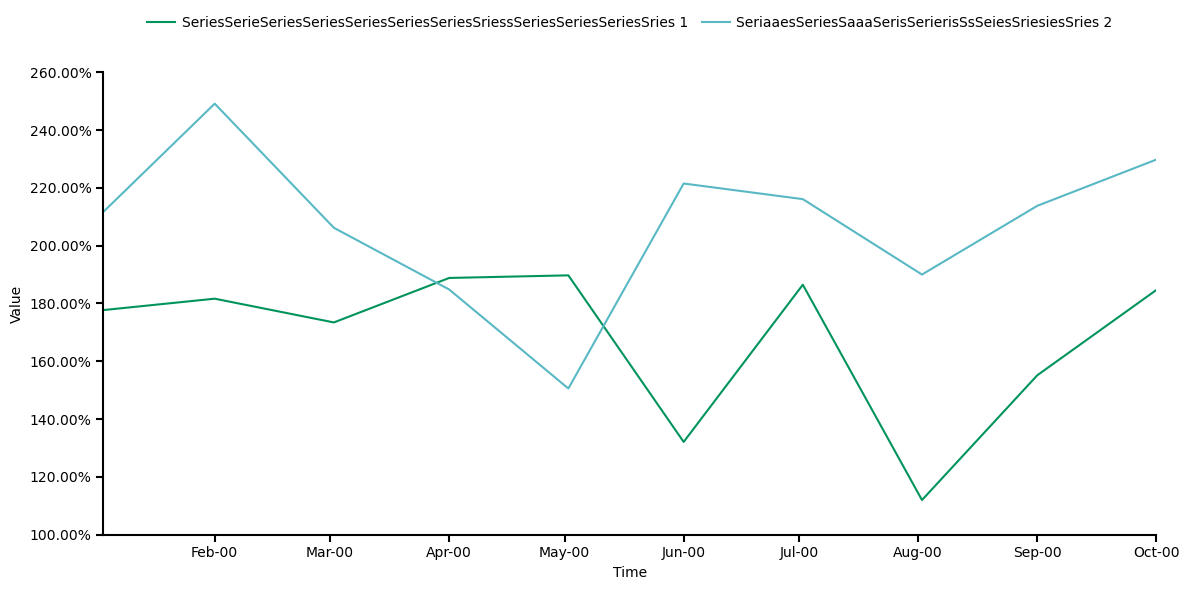

In [75]:
# Custom colorpalette
# Colors dictionary
colorpalette = {
    'blue': (0/250, 145/250, 90/250),
    'green': (86/250, 180/250, 192/250),
    'red': (215/250, 48/250, 48/250),
    'orange': (239/250, 123/250, 90/250),
    'grey_light': (217/250, 217/250, 217/250)
}

# Example data
dates = pd.date_range(start="2000-01-01", periods=10, freq='ME')
series1 = pd.DataFrame({'value': np.random.uniform(100, 200, size=len(dates))}, index=dates)
series2 = pd.DataFrame({'value': np.random.uniform(150, 250, size=len(dates))}, index=dates)

series_dict = {
    'SeriesSerieSeriesSeriesSeriesSeriesSeriesSriessSeriesSeriesSeriesSries 1': series1,
    'SeriaaesSeriesSaaaSerisSerierisSsSeiesSriesiesSries 2': series2
}

# Call the plotting function
simple_time_series_plot(
    data_or_dict=series_dict,
    increment=1,           # x-axis step
    buffer_ratio=0.15,
    last='no',
    value_type='percentage',
    decimals=2,
    colorpalette=colorpalette
)


In [64]:
colorpalette

{'SeriesSerieSeriesSeriesSeriesSeriesSeriesSriessSeriesSeriesSeriesSries 1': (86,
  180,
  192),
 'SeriaaesSeriesSaaaSerisSerierisSsSeiesSriesiesSries 2': (215, 48, 48)}

In [32]:

##############################################################################
# 3) Create a single unique DataFrame with 2 columns
##############################################################################
dates = pd.date_range("2020-01-01", periods=50, freq="M")
df = pd.DataFrame({
    "Close": np.random.uniform(50, 100, size=50),
    "Volume": np.random.uniform(100, 500, size=50)
}, index=dates)

df

/var/folders/y0/5dv_k1x105l2r3xvbg3mwj3h0000gn/T/ipykernel_4869/4159641502.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range("2020-01-01", periods=50, freq="M")


,Close,Volume
2020-01-31,79.674334,147.257025
2020-02-29,72.411473,168.909955
2020-03-31,52.205183,426.727904
2020-04-30,79.831859,415.622351
2020-05-31,95.001395,382.811302
2020-06-30,66.995911,499.993149
2020-07-31,99.561268,158.130917
2020-08-31,82.270159,139.430408
2020-09-30,54.670229,126.175886
2020-10-31,77.823608,287.527954
